# ISSR Prediction Models

## Imports

In [258]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import numpy as np
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot

## Load Dataset

In [259]:
data = pd.read_csv("C:/Users/Nicholas Weber/Downloads/Buffalo_issr2021.csv")

In [260]:
data.head()

,id_,year,month,day,hour,reltime,numlev,p_src,np_src,lat,...,timestamp,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling
0,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:00,33.62,274.05,353.44,0.727,no,1-1,0.25,0.0,0.0
1,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:01,33.62,274.05,363.64,0.727,no,1-1,0.25,0.0,0.0
2,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:00:25,32.00,273.15,763.30,0.740,no,1-1,0.25,0.0,0.0
3,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:01:04,28.76,271.35,1507.31,0.737,no,1-1,0.25,0.0,0.0
4,#USM00072528,2021,1,1,0,2310,176,ncdc-nws,ncdc-nws,429411,...,2021-01-01 00:01:58,24.08,268.75,2498.86,0.859,no,1-1,0.25,0.0,0.0


## Filter to 2022 and 2023

In [261]:
df = data[data['year'] >= 2022]

## Preprocessing

### Convert issc from characters to integers

In [262]:
warnings.filterwarnings("ignore")
df['issc'] = df['issc'].replace({'yes': 1, 'no': 0})

In [263]:
df

,id_,year,month,day,hour,reltime,numlev,p_src,np_src,lat,...,timestamp,temp_f,temp_k,press_alt,rh_ice,issc,day_of_year,volume,floor,ceiling
133,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:00,40.28,277.75,786.48,0.908,0,1-1,0.25,0.0,0.0
134,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:18,40.46,277.85,1168.85,0.882,0,1-1,0.25,0.0,0.0
135,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:27,41.36,278.35,1332.83,0.781,0,1-1,0.25,0.0,0.0
136,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:00:29,41.54,278.45,1372.03,0.784,0,1-1,0.25,0.0,0.0
137,#USM00072528,2022,1,1,0,2301,227,ncdc-nws,ncdc-gts,429411,...,2022-01-01 00:01:10,37.94,276.45,2135.52,0.952,0,1-1,0.25,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332205,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:00:00,-9999.00,-9999.00,-99.99,-9999.000,0,12-31,0.25,0.0,0.0
332206,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:00:00,-9999.00,-9999.00,-99.99,-9999.000,0,12-31,0.25,0.0,0.0
332207,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:00:00,-9999.00,-9999.00,-99.99,-9999.000,0,12-31,0.25,0.0,0.0
332208,#USM00072528,2023,12,31,12,1109,223,ncdc-nws,ncdc-gts,429411,...,2023-12-31 12:00:00,-9999.00,-9999.00,-99.99,-9999.000,0,12-31,0.25,0.0,0.0


### Creating X and Y variables

In [264]:
X = df[['month', 'day', 'hour', 'etime', 'press', 'temp_f', 'press_alt', 'rh_ice', 'dpdp', 'volume']]
y = df['issc']

### Undersample as there is an imbalance in yes and no for issc

In [265]:
rus = RandomUnderSampler(random_state=42)

In [266]:
X_resampled, y_resampled = rus.fit_resample(X, y)

### Split the dataset into train and test

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

In [268]:
scaler = StandardScaler()
X_trained_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fit to logistic regression model

In [269]:
model = LogisticRegression()
model.fit(X_trained_scaled, y_train)

LogisticRegression()

In [270]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9294871794871795


In [271]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[68, 10],
       [ 1, 77]], dtype=int64)

In [272]:
data = pd.concat([X, y], axis = 1)

<Axes: >

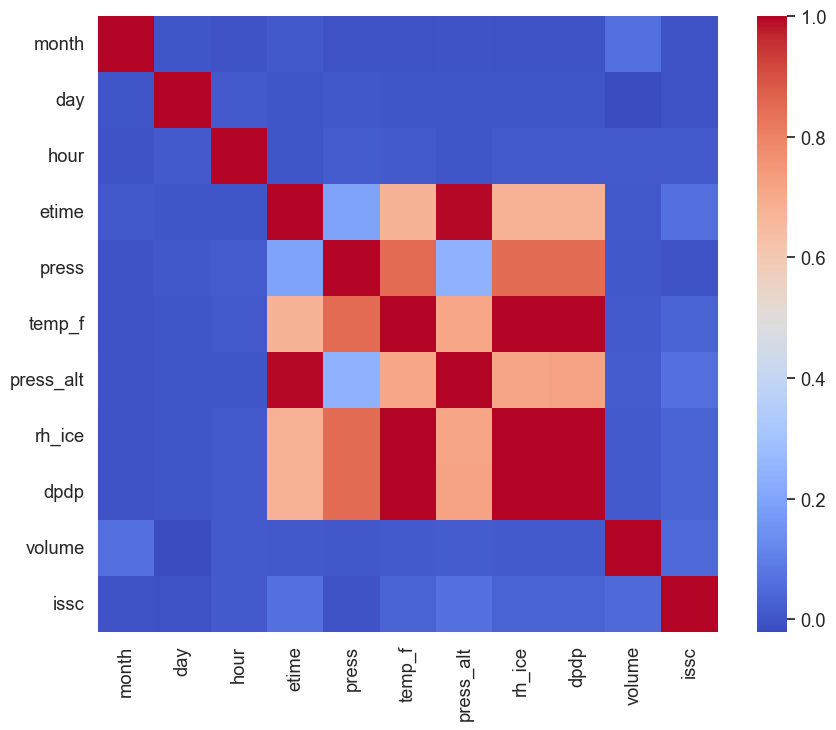

In [273]:
# Plot correlation matrix as heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2) 

sns.heatmap(data.corr(), fmt='.2f', cmap='coolwarm')

## Time Series Modeling

In [298]:
#Create DataFrame with volume column. Volume is based off of the number of times per day that an issc was yes
df['date'] = pd.to_datetime(df['date'])
issc_counts_per_day = df[df['issc'] == 1].groupby(df['date'].dt.date).size()
all_dates = pd.DataFrame(index=pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D'))
issc_counts_per_day.name = 'volume'
new_df = all_dates.join(issc_counts_per_day, how='left').fillna(0)

In [299]:
new_df

,volume
2022-01-01,0.0
2022-01-02,1.0
2022-01-03,0.0
2022-01-04,0.0
2022-01-05,0.0
...,...
2023-12-27,1.0
2023-12-28,0.0
2023-12-29,0.0
2023-12-30,3.0


### Autoregressive Integrated Moving Average (ARIMA) Model

In [300]:
#Source: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#Source: https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp
#ARIMA is statistical analysis model that uses time series data to predict future trends. This model can predict
#future values based on past values. ARIMA parameters include:
#p: the number of lag observations in the model
#d: the number of times the raw observations are differenced
#q: the size of the moving average window
#The ARIMA model identifies the appropriate number of lags.

#Splitting Training and Testing set
train_size = int(0.8 * len(new_df))
train, test = new_df.iloc[:train_size], new_df.iloc[train_size:]

# Fit ARIMA model
#Order represents, p, d, q. 
model = ARIMA(train['volume'], order=(5,1,0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test))

In [301]:
#Root Mean Squared Error is used to evaluate the model. RMSE takes the square root fo the average of the squared
#differences between the predicted values and the actual values.The lower the RMSE, the more accurate the model.
rmse = np.sqrt(mean_squared_error(test['volume'], predictions))

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 1.1041639743225553


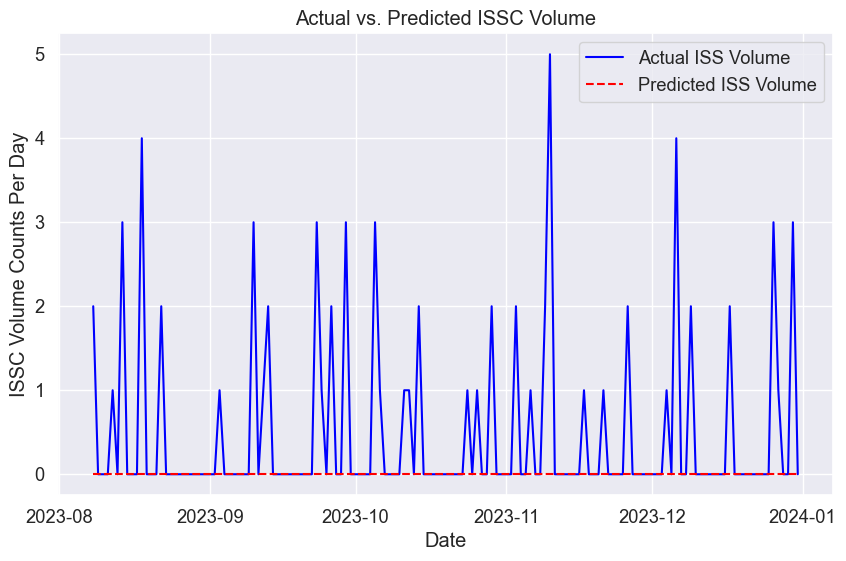

In [302]:
#Plotting Predicted versus Actual ISSC Volume Per Day
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['volume'], label='Actual ISS Volume', color='blue')
plt.plot(test.index, predictions, label='Predicted ISS Volume', color='red', linestyle='--')
plt.title('Actual vs. Predicted ISSC Volume')
plt.xlabel('Date')
plt.ylabel('ISSC Volume Counts Per Day')
plt.legend()
plt.grid(True)
plt.show()

Analysis: First attempt at ARIMA did not yield great results. Need to try different parameters.

### Long Short Term Momory (LSTM)

In [303]:
#Source: https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/
#Source: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
#LSTM is an improvement of Reccurent Neural Networks. LSTM has a memory cell, which holds information for an extended period,
#which allows the model to learn long-term dependencies. 

#Input the number of lag features
num_lags = 2

#Create loop to add lag features to dataframe
for i in range(1, num_lags + 1):
    new_df[f'volume_lag{i}'] = new_df['volume'].shift(i)
    
# Fill missing values with 0
new_df['volume_lag1'] = new_df['volume_lag1'].fillna(0)
new_df['volume_lag2'] = new_df['volume_lag2'].fillna(0)

In [304]:
new_df

,volume,volume_lag1,volume_lag2
2022-01-01,0.0,0.0,0.0
2022-01-02,1.0,0.0,0.0
2022-01-03,0.0,1.0,0.0
2022-01-04,0.0,0.0,1.0
2022-01-05,0.0,0.0,0.0
...,...,...,...
2023-12-27,1.0,3.0,0.0
2023-12-28,0.0,1.0,3.0
2023-12-29,0.0,0.0,1.0
2023-12-30,3.0,0.0,0.0


In [305]:
#Input x and y variables
X1 = new_df[['volume_lag1', 'volume_lag2']].values
y1 = new_df['volume'].values

#LSTM model
#Units = Dimensionality of the output space
#Activation = Activation Function, using relu, which is rectified linear unit
#Input_Shape: The shape of the input data that will be inputted into the LSTM
#Dense: A 1 in Dense specifies that there is only one desired output. 
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X1.shape[1], 1)),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Fit model. 
#Epoch is the amount fo times we pass the entire trainign set through the neural network
#Batch_size is the number of training samples per iteration
#Verbose displays information while the model runs
model.fit(X1, y1, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
23/23 [==============================] - 2s 2ms/step - loss: 5.4905
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 5.4138
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 5.3467
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 5.2966
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 5.2480
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 5.2253
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 5.2090
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 5.2006
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 5.2006
Epoch 10/100
23/23 [==============================] - 0s 3ms/step - loss: 5.2009
Epoch 11/100
23/23 [==============================] - 0s 3ms/step - loss: 5.1966
Epoch 12/100
23/23 [==============================] - 0s 3ms/step - loss: 5.1968
Epoch 13/100
23/23 [=================

23/23 [==============================] - 0s 2ms/step


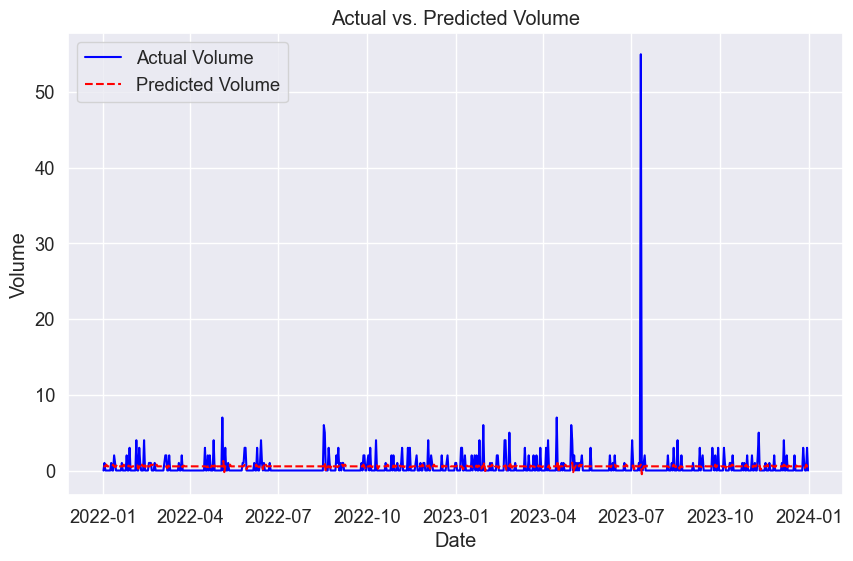

In [306]:
#Plotting actual vs. predicted issc volumes each day
actual_volume = new_df['volume']
predicted_volume = model.predict(X1)

# Plot actual vs. predicted volumes
plt.figure(figsize=(10, 6))
plt.plot(actual_volume.index, actual_volume, label='Actual Volume', color='blue')
plt.plot(actual_volume.index, predicted_volume, label='Predicted Volume', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Actual vs. Predicted Volume')
plt.legend()
plt.grid(True)
plt.show()

### Predicting the volume of issc for the next calandar day

In [307]:
#Extrating the last two volume lag variables
latest_volume_lag1 = new_df[['volume_lag1', 'volume_lag2']].iloc[-1]

# Reshape the input data
#Convert into an array
X_pred = np.array([latest_volume_lag1])
#Reshape the X_pred into the proper format for LSTM which is number of samples, number of timesteps, and number of features
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

# Make prediction
predicted_volume = model.predict(X_pred)

#Get the last date
latest_date = new_df.index[-1].date()

#Calculate the day we are predicitng for
next_date = latest_date + pd.DateOffset(days= 1)

#Outputting prediction
print(f"Predicted volume for {next_date}:", predicted_volume[0][0])

1/1 [==============================] - 0s 178ms/step
Predicted volume for 2024-01-01 00:00:00: 0.52784854


Analysis: In this preliminary LSTM model, we are recieiving a high loss rate (difference between predicted and actual values) of 5.1436. This is likely due to an outlier in the data, which is skewing the loss rate.

### LSTM with Removing Outlier

As shown in the last chart, there is an outlier in the data, which is causing the high loss rate. We will try again after removing the outlier from the dataset. 

In [308]:
#Removing outlier
outlier_df = new_df[new_df.index != '2023-07-11']

In [312]:
outlier_df

,volume,volume_lag1,volume_lag2
2022-01-01,0.0,0.0,0.0
2022-01-02,1.0,0.0,0.0
2022-01-03,0.0,1.0,0.0
2022-01-04,0.0,0.0,1.0
2022-01-05,0.0,0.0,0.0
...,...,...,...
2023-12-27,1.0,3.0,0.0
2023-12-28,0.0,1.0,3.0
2023-12-29,0.0,0.0,1.0
2023-12-30,3.0,0.0,0.0


In [313]:
#Fitting model
X2 = outlier_df[['volume_lag1', 'volume_lag2']].values
y2 = outlier_df['volume'].values

model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X2.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(X2, y2, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
23/23 [==============================] - 1s 2ms/step - loss: 1.2963
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 1.2307
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 1.1860
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1557
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 1.1415
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1337
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1315
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1282
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1285
Epoch 10/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1268
Epoch 11/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1261
Epoch 12/100
23/23 [==============================] - 0s 3ms/step - loss: 1.1261
Epoch 13/100
23/23 [=================

### LSTM Remove Outlier and Create Train and Test sets

In [318]:
#This is where we incorporate train and test to validate how well the model is performing. 
# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Fit model on training data
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Evaluate model on testing data
loss = model.evaluate(X_test, y_test)
print('Testing Loss:', loss)

Epoch 1/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2307
Epoch 2/50
19/19 [==============================] - 0s 2ms/step - loss: 1.2292
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2317
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2314
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2306
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2303
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2339
Epoch 8/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2304
Epoch 9/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2349
Epoch 10/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2328
Epoch 11/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2301
Epoch 12/50
19/19 [==============================] - 0s 3ms/step - loss: 1.2308
Epoch 13/50
19/19 [==============================

23/23 [==============================] - 0s 2ms/step


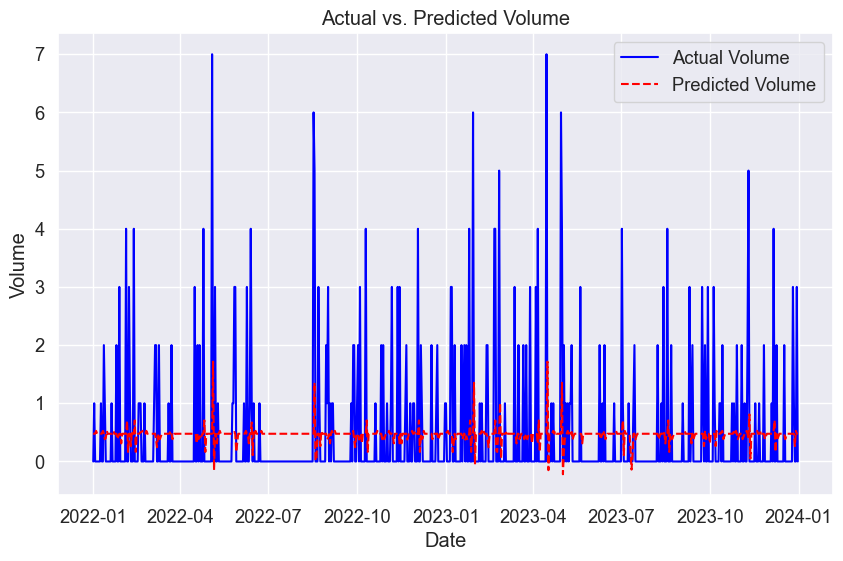

In [319]:
#Plotting actual vs. predicted issc volumes each day
actual_volume = outlier_df['volume']
predicted_volume = model.predict(X2)

# Plot actual vs. predicted volumes
plt.figure(figsize=(10, 6))
plt.plot(actual_volume.index, actual_volume, label='Actual Volume', color='blue')
plt.plot(actual_volume.index, predicted_volume, label='Predicted Volume', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Actual vs. Predicted Volume')
plt.legend()
plt.grid(True)
plt.show()

### Predicting the volume of issc for the next calandar day

In [327]:
latest_volume_lag12 = outlier_df[['volume_lag1', 'volume_lag2']].iloc[-1]
# Reshape the input data
X_pred = np.array([latest_volume_lag12])
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1], 1)

# Make predictions
predicted_volume = model.predict(X_pred)

#Get the last date
latest_date = new_df.index[-1].date()

#Calculate the day we are predicitng for
next_date = latest_date + pd.DateOffset(days= 1)

print(f"Predicted volume for {next_date}:", predicted_volume[0][0])

1/1 [==============================] - 0s 19ms/step
Predicted volume for 2024-01-01 00:00:00: 0.47294468


Analysis: After removing the outlier, the LSTM model seems to perform better with bringing the training loss from 5.1436 to 1.2290. When analyzing the plot, appears to follow the actual volume decent, however, has trouble predicitng the extrme values. Although it may not guess if a day will have multiple instances of issc, it still might forecast the presence of at least 1. 

## Cross Validation/Grid Search

In [231]:
#Need to determine the optimal parameters and number of lag variables